Project 5 - Vehicle Detection - Report. Vilas Chitrakaran. March 2017

# Executive Summary
The objective is to develop a software pipeline to identify and track vehicles in a video stream obtained from a front-facing camera mounted on the dashboard of a car. A linear support vector machine (SVM) is trained to identify vehicles based on histogram-of-oriented-gradients (HOG) features extracted from 'car' and 'non-car' image sets. The trained SVM is then applied on the video stream to search and identify vehicles. The robustness of the identification pipeline is improved by temporal filtering techniques to discard false positives. 

The following video demonstrates the final result obtained from my implementation.

__TODO__: Link to final video

# Processing Pipeline Development

__TODO__: Give an overview of sequence of development

The vehicle is instrumented with a front-facing video camera that provides an RGB video stream of the road ahead.

__NOTE__: Why am I anal about memory usage by deleting training variables after use? Not able to go past training stage on my laptop

Number of car images in the dataset: 8792
Number of non-car images in the dataset: 8968


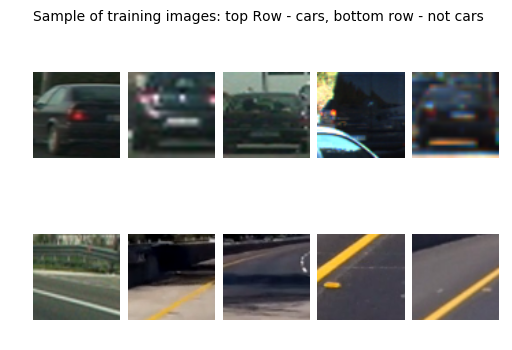

In [1]:
#=====================================================================
# Prepare list of image files used for training

import gc
import glob
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# read in image as RGB
def read_image(filename):
    image = cv2.imread(filename)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

trainingImages = glob.glob('./training_set/**/*.png', recursive=True)
carImageNames = []
notCarImageNames = []

for filename in trainingImages:
    if 'non-vehicles' in filename:
        notCarImageNames.append(filename)
    else:
        carImageNames.append(filename)

print('Number of car images in the dataset:', len(carImageNames))
print('Number of non-car images in the dataset:', len(notCarImageNames))

# Select a random set of car and non-car images and show it
fig,ax = plt.subplots(2,5)
fig.suptitle('Sample of training images: top Row - cars, bottom row - not cars')
for i in range(5):
    ax[0,i].imshow(read_image(carImageNames[np.random.randint(0, len(carImageNames))]))
    ax[0,i].axis('off')
    
    ax[1,i].imshow(read_image(notCarImageNames[np.random.randint(0, len(notCarImageNames))]))
    ax[1,i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# free up variables after use. I have limited resources on my machine
del trainingImages
gc.collect();

## Feature Extraction - Histogram of Oriented Gradients (HOG)
Why use HOG? spatial features add robustness. yCrCb seems to work better than HSV in some test images

Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

we will hard code these parameters
- colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
- orient = 9
- pix_per_cell = 8
- cell_per_block = 2
- hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"



Feature vector length: 6093


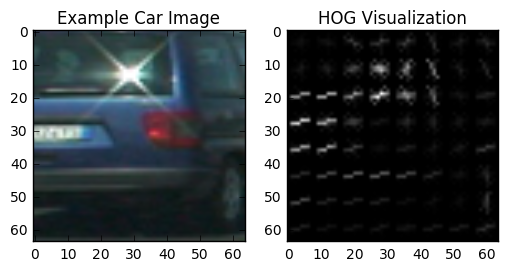

In [4]:
#=====================================================================
# Feature extraction

from skimage.feature import hog
   
# Wrapper to apply a chosen color conversion to an RGB image
def convert_color(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

def get_spatial_features(image):
    size = 16 
    return cv2.resize(image, (size, size)).ravel()

def get_histogram_features(image):
    numBins=16
    binsRange=(0, 256)
    features = []
    for channel in range(image.shape[2]):
        ch = np.histogram(image[:,:,channel], bins=numBins, range=binsRange)
        features = np.concatenate(ch)
    return features


# Given an image, generate HOG feature vector for the image with the following chosen parameters
# 9 orientation, 8x8 pixels per cell, 2x2 cells per block
# image - single channel image
# bVisual - If True, also return an image of the HOG
# bFeatVec - If True, return the data as a feature vector by calling .ravel() on the result just before returning.
def get_hog_features(image, bVisual=False, bFeatVec=True):
    # if bVisual == True, return features, hog_image, else just return features
    return hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
               transform_sqrt=False, visualise=bVisual, feature_vector=bFeatVec)

# Create a feature vector for an image. The image must be RGB and all channels of the image are used
def extract_features(image):
    featureImage = convert_color(image) # apply color conversion
    spatialFeatures = get_spatial_features(featureImage)
    histFeatures = get_histogram_features(featureImage)
    hogFeatures = [] # get HOG features for all channels
    for channel in range(featureImage.shape[2]):
        hogFeatures.append(get_hog_features(featureImage[:,:,channel], bVisual=False, bFeatVec=True))
    hogFeatures = np.ravel(hogFeatures)
    return np.concatenate((spatialFeatures, histFeatures, hogFeatures))

# Create an array of feature vectors
def extract_features_from_files(imageFileNames):
    features = [] # Create a list to append feature vectors to
    for file in imageFileNames: # Iterate through the list of images
        image = read_image(file)        
        features.append(extract_features(image))
    return features # Return list of feature vectors

# Test feature extractor on a single channel image
index = np.random.randint(0, len(carImageNames))
image = read_image(carImageNames[index])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
hogFeatures, hogImage = get_hog_features(gray, bVisual=True, bFeatVec=False)
features = extract_features(image)
print('Feature vector length:',len(features))

fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hogImage, cmap='gray')
plt.title('HOG Visualization')
plt.show()

# free up variables after use. I have limited resources on my machine
del features, hogFeatures, hogImage, image, gray
gc.collect();

## Classifier Training - Support Vector Machine

Why use SVM and not something else?

Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).



66.44 Seconds to extract features from 12000 training samples.


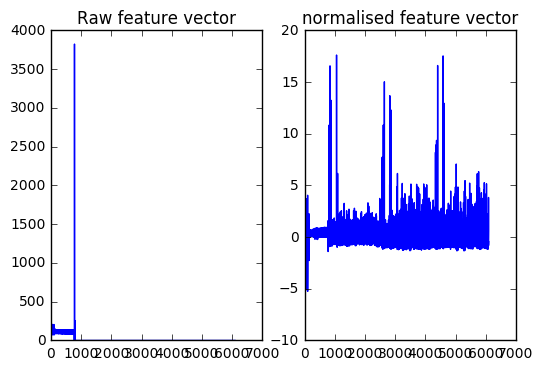

Number of images in the training set: 9600
Number of images in the test set: 2400


In [5]:
#=====================================================================
# Classifier training - prepare training and test datasets

import time
import random
import sklearn
from sklearn.preprocessing import StandardScaler

# need scikit-learn version to determine how to import train_test_split
(skl_major, skl_minor, _) = sklearn.__version__.split(".")

if int(skl_major) == 0 and int(skl_minor) <= 17:
    from sklearn.cross_validation import train_test_split
if int(skl_major) == 0 and int(skl_minor) > 17:
    from sklearn.model_selection import train_test_split

# Pick a random subset of the training set to train the classifier on, due to
# computational constraints I have on my laptop.
sampleSize = 6000
carImageNamesSet = random.sample(carImageNames, sampleSize)
notCarImageNamesSet = random.sample(notCarImageNames, sampleSize)

# Extract features from training images
t=time.time()
carFeatures = extract_features_from_files(carImageNamesSet)
notCarFeatures = extract_features_from_files(notCarImageNamesSet)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features from', len(carFeatures)+len(notCarFeatures), 'training samples.')

# Create an array stack of feature vectors 
featureStack = np.vstack((carFeatures, notCarFeatures)).astype(np.float64)                        
featureScaler = StandardScaler().fit(featureStack) # Fit a per-column scaler
scaledFeatureStack = featureScaler.transform(featureStack) # Apply the scaler

# Define the labels vector
labelStack = np.hstack((np.ones(len(carFeatures)), np.zeros(len(notCarFeatures))))

# plot a randomly selected feature vector
indx = np.random.randint(0, len(featureStack))
fig = plt.figure()
plt.subplot(121)
plt.plot(featureStack[indx])
plt.title('Raw feature vector')
plt.subplot(122)
plt.plot(scaledFeatureStack[indx])
plt.title('normalised feature vector')
plt.show()

# Split up training data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaledFeatureStack, labelStack, 
                                                    test_size=0.2, random_state=rand_state)

print('Number of images in the training set:', len(X_train))
print('Number of images in the test set:', len(X_test))

# free up variables after use. I have limited resources on my machine
del carImageNames, notCarImageNames, carImageNamesSet, notCarImageNamesSet
del carFeatures, notCarFeatures, featureStack
del scaledFeatureStack, labelStack
gc.collect();

In [6]:
#=====================================================================
# Classifier training - do the training

from sklearn.svm import LinearSVC

# Create Linear Support Vector Machine and use it as the classifier 
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time 
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# free up variables after use. I have limited resources on my machine
del X_train, X_test, y_train, y_test
gc.collect();

11.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9908
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  0.  1.  1.]
0.00167 Seconds to predict 10 labels with SVC


## Vehicle Detection - Sliding Window Search
Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?



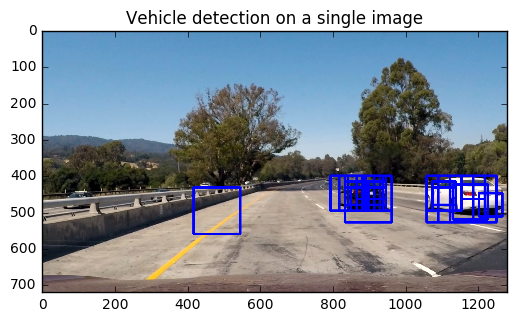

In [84]:
#=====================================================================
# Vehicle detection - sub-sampling window search

# Find cars in a sub-region of the image and return corresponding bounding boxes
def find_cars(image, ystart, ystop, scale, svc, X_scaler):
    
    # we will accumulate a list of potential vehicle locations here in the form [((x1, y1), (x2, y2)),...]
    bboxes = []
    
    # Take the specified ROI in the image and transform the color space
    subImage = image[ystart:ystop,:,:]
    colorTransImage = convert_color(subImage)
    
    # re-scale image to find vehicles at scale specified
    if scale != 1:
        imshape = colorTransImage.shape
        colorTransImage = cv2.resize(colorTransImage, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # break the image into channels
    ch1 = colorTransImage[:,:,0]
    ch2 = colorTransImage[:,:,1]
    ch3 = colorTransImage[:,:,2]

    # pre-defined constants
    pixelsPerCell = 8
    cellsPerBlock = 2
    numOrientations = 9
    
    # Define blocks and steps as above
    numBlocksX = (ch1.shape[1] // pixelsPerCell)-1
    numBlocksY = (ch1.shape[0] // pixelsPerCell)-1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    numBlocksPerWindow = (window // pixelsPerCell)-1
    
    cellsPerStep = 2  # define how many cells to step across as we slide the window
    numStepsX = (numBlocksX - numBlocksPerWindow) // cellsPerStep
    numStepsY = (numBlocksY - numBlocksPerWindow) // cellsPerStep
       
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, bFeatVec=False)
    hog2 = get_hog_features(ch2, bFeatVec=False)
    hog3 = get_hog_features(ch3, bFeatVec=False)
    
    # slide window across and calculate the feature vector as we go
    for xb in range(numStepsX):
        for yb in range(numStepsY):
            yPos = yb * cellsPerStep
            xPos = xb * cellsPerStep
            
            # Extract HOG for this patch
            hogFeatures1 = hog1[yPos:yPos+numBlocksPerWindow, xPos:xPos+numBlocksPerWindow].ravel() 
            hogFeatures2 = hog2[yPos:yPos+numBlocksPerWindow, xPos:xPos+numBlocksPerWindow].ravel() 
            hogFeatures3 = hog3[yPos:yPos+numBlocksPerWindow, xPos:xPos+numBlocksPerWindow].ravel() 
            hogFeatures = np.hstack((hogFeatures1, hogFeatures2, hogFeatures3))

            xLeft = xPos * pixelsPerCell
            yTop = yPos * pixelsPerCell

            # Extract the image patch
            patchImage = cv2.resize(colorTransImage[yTop:yTop+window, xLeft:xLeft+window], (64,64))
          
            # Get color features
            spatialFeatures = get_spatial_features(patchImage)
            histogramFeatures = get_histogram_features(patchImage)

            # Scale features and make a prediction
            testFeatures = X_scaler.transform(
                np.hstack((spatialFeatures, histogramFeatures, hogFeatures)).reshape(1, -1))    
            testPrediction = svc.predict(testFeatures)
            
            # if we found a car, add the bounding box to the list
            if testPrediction == 1:
                xBoxLeft = np.int(xLeft * scale)
                yBoxTop = np.int(yTop * scale)
                winSize = np.int(window * scale)
                bbox = ((xBoxLeft, yBoxTop+ystart),(xBoxLeft+winSize,yBoxTop+winSize+ystart)) 
                bboxes.append(bbox)
                
    return bboxes

# Test it
image = read_image('./test_images/test1.jpg')
yStart = 400
yStop = 650
scales = [1,1.5,2]
bboxes = []
for scale in scales:
    bboxes += find_cars(image, yStart, yStop, scale, svc, featureScaler)

for bbox in bboxes:
    cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
plt.imshow(image)
plt.title('Vehicle detection on a single image')
plt.show()

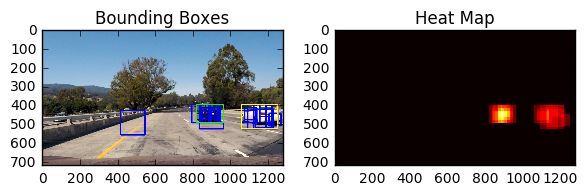

In [46]:
#=====================================================================
# Heatmap generation

from scipy.ndimage.measurements import label

# Create a heatmap given potentially overlapping bounding boxes
def create_heatmap(width, height, boundingBoxesList):
    heatImage = np.zeros((width,height)).astype(np.float)
    for box in boundingBoxesList:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatImage[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatImage

# Threshold the heatmap
def threshold_heatmap(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0 # Zero out pixels below the threshold
    return heatmap

def draw_labeled_bboxes(image, labels, colors):
    for carNumber in range(1, labels[1]+1):
        nonzero = (labels[0] == carNumber).nonzero() # Find pixels with each carNumber label value
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], colors[carNumber], 6)
    # Return the image
    return image

# Test

# Create the heatmap
heatImage = create_heatmap(image.shape[0], image.shape[1], bboxes)
    
# Apply threshold to help remove false positives
heatImage = threshold_heatmap(heatImage,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heatImage, 0, 255)

# Find final boxes from heatmap using label function
colors = [(255,0,0),(0,255,0),(255,255,0),(0,0,255),(255,0,255),(0,255,255)]
labels = label(heatmap)
labelledImage = draw_labeled_bboxes(np.copy(image), labels, colors)

fig = plt.figure()
plt.subplot(121)
plt.imshow(labelledImage)
plt.title('Bounding Boxes')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

## Processing Pipeline
Summarise the steps in the processing pipeline. 

Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Combine vehicle detection with lane detection

In [70]:
#=====================================================================
# Processing pipeline

#TODO
# - method print_statistics()
# - check previous bboxes are being used correctly
# - check (scale,yStop) combinations are correct and revise them to set yStops correctly for the given scales

class VehicleDetector:
    
    def __init__(self):
        self._prevBboxes = []
        self._numFrames = 0
        
    def process_image(self,image):

        self._numFrames += 1
        
        # region of the image we will search for vehicles, and the scales we will search at
        yStart = 400
        yStops = [550,600,650]
        scales = [1,1.5,2]

        # find bounding boxes enclosing vehicles at all scales
        bboxes = []
        for scale,yStop in zip(scales,yStops):
            bboxes += find_cars(image, yStart, yStop, scale, svc, featureScaler)

        # add list of bounding boxes from previous image(or last n images)
        cumBboxes = bboxes + self._prevBboxes
        self._prevBboxes = bboxes;
        
        # generate heatmap for combined list of bounding boxes
        heatImage = create_heatmap(image.shape[0], image.shape[1], cumBboxes)

        # Apply threshold to help remove false positives
        heatImage = threshold_heatmap(heatImage,1)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heatImage, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        colors = [(127,127,127),(255,0,0),(0,255,0),(255,255,0),(0,0,255),(255,0,255),(0,255,255),(255,255,255)]
        labelledImage = draw_labeled_bboxes(np.copy(image), labels, colors)
        return labelledImage

# Vehicle Detection - Project Video
All that remains now is to process the video sequence by applying the processing pipeline described in the previous section.

In [72]:
#=====================================================================
# process the project video

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video_name = 'output.mp4'
input_video = VideoFileClip("test_video.mp4")

processor = VehicleDetector()
process_image = processor.process_image

output_video = input_video.fl_image(process_image)
%time output_video.write_videofile(output_video_name, audio=False)
print('Number of frames processed:', processor._numFrames)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<21:55,  1.04s/it]

  0%|          | 2/1261 [00:02<22:08,  1.05s/it]

  0%|          | 3/1261 [00:03<22:12,  1.06s/it]

  0%|          | 4/1261 [00:04<22:08,  1.06s/it]

  0%|          | 5/1261 [00:05<22:34,  1.08s/it]

  0%|          | 6/1261 [00:06<22:18,  1.07s/it]

  1%|          | 7/1261 [00:07<22:04,  1.06s/it]

  1%|          | 8/1261 [00:08<22:27,  1.08s/it]

  1%|          | 9/1261 [00:09<23:11,  1.11s/it]

  1%|          | 10/1261 [00:10<22:39,  1.09s/it]

  1%|          | 11/1261 [00:11<22:37,  1.09s/it]

  1%|          | 12/1261 [00:12<22:18,  1.07s/it]

  1%|          | 13/1261 [00:14<22:51,  1.10s/it]

  1%|          | 14/1261 [00:15<22:27,  1.08s/it]

  1%|          | 15/1261 [00:16<22:14,  1.07s/it]

  1%|▏         | 16/1261 [00:17<21:52,  1.05s/it]

  1%|▏         | 17/1261 [00:18<21:41,  1.05s/it]

  1%|▏         | 18/1261 [00:19<22:00,  1.06s/it]

  2%|▏         | 19/1261 [00:20<21:45,  1.05s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 1h 8min 5s, sys: 1min 13s, total: 1h 9min 19s
Wall time: 22min 42s
Number of frames processed: 1261


# Conclusions
Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?